## TP2: Classification des textes 

#### Description synthétique du Projet :

Ce projet consiste à développer un modèle de classification des critiques de films en langue française en fonction de leur tonalité, positive ou négative. L'objectif est d'explorer et de comparer les performances des méthodes traditionnelles de traitement du langage naturel (NLP) avec celles basées sur l'apprentissage profond.

#### Objectifs du Projet :

Mettre en place un pipeline de prétraitement des textes en se basant sur des règles NLP.

Réaliser un baseline en utilisant des méthodes simples telles que bag-of-words et TF-IDF, ainsi que deux algorithmes de classification.

Encoder les textes en utilisant un modèle word2vec pré-entraîné pour la langue française.

Utiliser des réseaux de neurones récurrents (LSTM) pour la classification des critiques.

Expérimenter avec différentes architectures et optimiseurs LSTM et documenter les résultats.

Évaluer la performance des différents modèles en se basant sur les matrices de confusion.

Analyser les erreurs des modèles et tenter de trouver des explications pour celles-ci.

**Bibliothèque utile**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from numpy import nan
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from math import sqrt
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## Importation des données

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
dataset = load_dataset("allocine")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [5]:
# Afficher les noms des sous-ensembles disponibles
print("Sous-ensembles disponibles :", dataset.keys())

Sous-ensembles disponibles : dict_keys(['train', 'validation', 'test'])


## Visualisation des données

In [6]:
# Accéder à l'ensemble des données
train_dataset = dataset["train"]
test_dataset = dataset["test"]
val_dataset = dataset["validation"]

In [7]:
train_dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 160000
})

In [8]:
# Obtenir des informations sur la structure des données
print("Structure des données :", dataset["train"].features)

Structure des données : {'review': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [9]:
# Afficher quelques exemples de critiques positives
print("\nExemples de critiques positives :")
for i in range(5):
    print(train_dataset[i]["review"], "- Classe :", train_dataset[i]["label"])

# Afficher quelques exemples de critiques négatives
print("\nExemples de critiques négatives :")
for i in range(5):
    print(train_dataset[-(i+1)]["review"], "- Classe :", train_dataset[-(i+1)]["label"])


Exemples de critiques positives :
Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme 

In [10]:
import pandas as pd
# Créer un DataFrame à partir des données
train_data = pd.DataFrame({'review': train_dataset['review'], 'label': train_dataset['label']})

test_data = pd.DataFrame({'review': test_dataset['review'], 'label': test_dataset['label']})

val_data = pd.DataFrame({'review': val_dataset['review'], 'label': test_dataset['label']})

# Afficher les premières lignes du DataFrame
train_data.head()

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  160000 non-null  object
 1   label   160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [13]:
train_data['label'].value_counts()

label
1    80587
0    79413
Name: count, dtype: int64

In [14]:
Sentiment_words=[]
for row in train_data['label']:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
train_data['Sentiment_words'] = Sentiment_words

In [15]:
word_count=pd.value_counts(train_data['Sentiment_words'].values, sort=False)
word_count

negative    79413
positive    80587
Name: count, dtype: int64

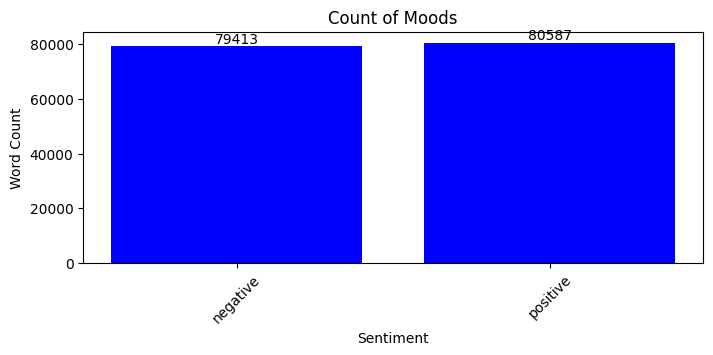

In [16]:
import matplotlib.pyplot as plt

# Définir les catégories et leurs index
categories = ['negative', 'positive']
indexes = range(len(categories))

# Créer un sous-ensemble des données de word_count pour les catégories spécifiées
category_counts = [word_count[cat] for cat in categories]

# Tracer le graphique
plt.figure(figsize=(8, 3))
plt.bar(indexes, category_counts, color='blue')
plt.xticks(indexes, categories, rotation=45)
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.title('Count of Moods')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


## Prétraitement des données

In [17]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [20]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_list = stopwords.words("french")
#stopwords_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
# Appliquer le prétraitement de texte aux données d'entraînement
train_data['cleaned_text'] = train_data['review'].apply(lambda x: utils_preprocess_text(x, lst_stopwords=stopwords_list))

# Appliquer le prétraitement de texte aux données de test
test_data['cleaned_text'] = test_data['review'].apply(lambda x: utils_preprocess_text(x, lst_stopwords=stopwords_list))

# Appliquer le prétraitement de texte aux données de validation
val_data['cleaned_text'] = val_data['review'].apply(lambda x: utils_preprocess_text(x, lst_stopwords=stopwords_list))

In [23]:
train_data.head()

,review,label,Sentiment_words,cleaned_text
0,Si vous cherchez du cinéma abrutissant à tous ...,0,negative,si cherchez cinéma abrutissant tous étagesnaya...
1,"Trash, re-trash et re-re-trash...! Une horreur...",0,negative,trash retrash reretrash horreur sans nom imagi...
2,"Et si, dans les 5 premières minutes du film, l...",0,negative,si 5 premières minute film pathétique maquette...
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0,negative,dieu quelle métaphore filée abasourdi réelleme...
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1,positive,premier film saga kozure okami sabre vengeance...


In [1]:
#train_data.drop(['review','Sentiment_words'],axis=1,inplace=True)
#test_data.drop(['review','Sentiment_words'],axis=1,inplace=True)
#val_data.drop(['review','Sentiment_words'],axis=1,inplace=True)

In [25]:
train_data.head()

,label,cleaned_text
0,0,si cherchez cinéma abrutissant tous étagesnaya...
1,0,trash retrash reretrash horreur sans nom imagi...
2,0,si 5 premières minute film pathétique maquette...
3,0,dieu quelle métaphore filée abasourdi réelleme...
4,1,premier film saga kozure okami sabre vengeance...


In [26]:
train_data.shape

(160000, 2)

## Séparation ds données 

In [27]:
# Pour les données d'entraînement
X_train = train_data['cleaned_text']
y_train = train_data['label']

# Pour les données de validation
X_val = val_data['cleaned_text']
y_val = val_data['label']

# Pour les données de test
X_test = test_data['cleaned_text']
y_test = test_data['label']


## Bag of word

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialisez le vectoriseur CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)  # Vous pouvez ajuster le nombre maximal de fonctionnalités selon vos besoins

# Transformez les données d'entraînement et de test en représentations bag-of-words
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Initialisez et entraînez un classificateur Naive Bayes multinomial
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_bow, y_train)

# Faites des prédictions sur les données de test
y_pred_nb = nb_classifier.predict(X_test_bow)

# Évaluez les performances du modèle
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Naive Bayes (Bag-of-Words) :", accuracy_nb)
print("Classification Report Naive Bayes (Bag-of-Words) :\n", classification_report(y_test, y_pred_nb))


Accuracy Naive Bayes (Bag-of-Words) : 0.8972
Classification Report Naive Bayes (Bag-of-Words) :
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     10408
           1       0.90      0.89      0.89      9592

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



## TF-IDF

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialisez le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transformez les données d'entraînement et de test en représentations TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialisez et entraînez un classificateur RandomForest
rf_classifier_tfidf = RandomForestClassifier(n_estimators=100)  # Vous pouvez ajuster les hyperparamètres selon vos besoins
rf_classifier_tfidf.fit(X_train_tfidf, y_train)

# Faites des prédictions sur les données de test
y_pred_rf_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)

# Évaluez les performances du modèle
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)
print("Accuracy RandomForest (TF-IDF) :", accuracy_rf_tfidf)
print("Classification Report RandomForest (TF-IDF) :\n", classification_report(y_test, y_pred_rf_tfidf))


Accuracy RandomForest (TF-IDF) : 0.87995
Classification Report RandomForest (TF-IDF) :
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     10408
           1       0.88      0.87      0.87      9592

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



## word2vec

In [29]:
import gensim
from gensim.models import KeyedVectors
import numpy as np

# Chemin vers le modèle Word2Vec préentraîné pour la langue française
path_to_model = "/content/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"

# Chargement du modèle Word2Vec
word2vec_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [30]:
# Fonction pour encoder un texte en utilisant le modèle Word2Vec
def encode_text(text, model):
    # Initialiser un vecteur de dimension fixe
    vector_size = model.vector_size
    encoded_text = np.zeros(vector_size)

    # Compter le nombre de mots dans le texte
    word_count = 0

    # Pour chaque mot dans le texte
    for word in text.split():
        # Si le mot est dans le vocabulaire du modèle Word2Vec
        if word in model:
            # Ajouter la représentation vectorielle du mot au vecteur encodé
            encoded_text += model[word]
            word_count += 1

    # Normaliser le vecteur encodé en divisant par le nombre de mots
    if word_count > 0:
        encoded_text /= word_count

    return encoded_text


In [39]:
# Encodage des données d'entraînement avec Word2Vec
X_train_encoded = [encode_text(text, word2vec_model) for text in X_train]

# Encodage des données de validation avec Word2Vec
X_val_encoded = [encode_text(text, word2vec_model) for text in X_val]

# Encodage des données de test avec Word2Vec
X_test_encoded = [encode_text(text, word2vec_model) for text in X_test]

In [40]:
print(len(X_train_encoded))  # Nombre d'exemples
print(X_train_encoded[0].shape)  # Dimensions du premier exemple

160000
(200,)


## LSTM

In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()

# Ajout de la couche LSTM
model.add(LSTM(100, input_shape=(None, 200), activation='relu'))

# Ajout de la couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [42]:
# Convertir les listes en tableaux numpy
X_train_encoded = np.array(X_train_encoded)
X_val_encoded = np.array(X_val_encoded)
X_test_encoded = np.array(X_test_encoded)

# Réformer les données d'entrée pour les rendre compatibles avec LSTM
X_train_reshaped = X_train_encoded.reshape(X_train_encoded.shape[0], 1, X_train_encoded.shape[1])
X_val_reshaped = X_val_encoded.reshape(X_val_encoded.shape[0], 1, X_val_encoded.shape[1])
X_test_reshaped = X_test_encoded.reshape(X_test_encoded.shape[0], 1, X_test_encoded.shape[1])

# Entraînement du modèle
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=10, batch_size=64)


Epoch 1/10
2500/2500 [==============================] - 19s 6ms/step - loss: 0.3811 - accuracy: 0.8358 - val_loss: 1.3864 - val_accuracy: 0.5018
Epoch 2/10
2500/2500 [==============================] - 31s 12ms/step - loss: 0.3509 - accuracy: 0.8491 - val_loss: 1.4191 - val_accuracy: 0.4999
Epoch 3/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3394 - accuracy: 0.8540 - val_loss: 1.4704 - val_accuracy: 0.4996
Epoch 4/10
2500/2500 [==============================] - 16s 7ms/step - loss: 0.3298 - accuracy: 0.8579 - val_loss: 1.4800 - val_accuracy: 0.5015
Epoch 5/10
2500/2500 [==============================] - 16s 7ms/step - loss: 0.3213 - accuracy: 0.8608 - val_loss: 1.5776 - val_accuracy: 0.5011
Epoch 6/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3137 - accuracy: 0.8656 - val_loss: 1.5370 - val_accuracy: 0.5023
Epoch 7/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3069 - accuracy: 0.8680 - val_loss: 1.6107 - val_

In [43]:

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy)

625/625 [==============================] - 2s 2ms/step - loss: 0.3166 - accuracy: 0.8635
Test Accuracy: 0.8634999990463257


In [45]:
# Remodelage des données d'entrée pour qu'elles soient tridimensionnelles
X_train_reshaped = np.reshape(X_train_encoded, (X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_val_reshaped = np.reshape(X_val_encoded, (X_val_encoded.shape[0], 1, X_val_encoded.shape[1]))
X_test_reshaped = np.reshape(X_test_encoded, (X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))


In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Création du modèle LSTM avec l'optimiseur RMSprop
model_rmsprop = Sequential()
model_rmsprop.add(LSTM(100, input_shape=(1, X_train_encoded.shape[1]), activation='relu'))
model_rmsprop.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model_rmsprop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history_rmsprop = model_rmsprop.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))


Epoch 1/10
2500/2500 [==============================] - 18s 6ms/step - loss: 0.3896 - accuracy: 0.8321 - val_loss: 1.3464 - val_accuracy: 0.5023
Epoch 2/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3560 - accuracy: 0.8471 - val_loss: 1.4070 - val_accuracy: 0.5009
Epoch 3/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3435 - accuracy: 0.8520 - val_loss: 1.4777 - val_accuracy: 0.4994
Epoch 4/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3338 - accuracy: 0.8563 - val_loss: 1.5697 - val_accuracy: 0.5037
Epoch 5/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3259 - accuracy: 0.8599 - val_loss: 1.5501 - val_accuracy: 0.5017
Epoch 6/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3188 - accuracy: 0.8632 - val_loss: 1.5503 - val_accuracy: 0.4997
Epoch 7/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.3135 - accuracy: 0.8657 - val_loss: 1.5376 - val_ac

In [47]:
# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy)

625/625 [==============================] - 2s 2ms/step - loss: 0.3166 - accuracy: 0.8635
Test Accuracy: 0.8634999990463257


In [52]:
# Prédiction sur les données de validation pour le modèle RMSprop
y_pred_rmsprop_probs = model_rmsprop.predict(X_val_reshaped)
y_pred_rmsprop = (y_pred_rmsprop_probs > 0.5).astype('int')  # Conversion en classes
conf_matrix_rmsprop = confusion_matrix(y_val, y_pred_rmsprop)
print("Matrice de confusion pour le modèle RMSprop :\n", conf_matrix_rmsprop)


625/625 [==============================] - 5s 7ms/step
Matrice de confusion pour le modèle RMSprop :
 [[5092 5316]
 [4660 4932]]


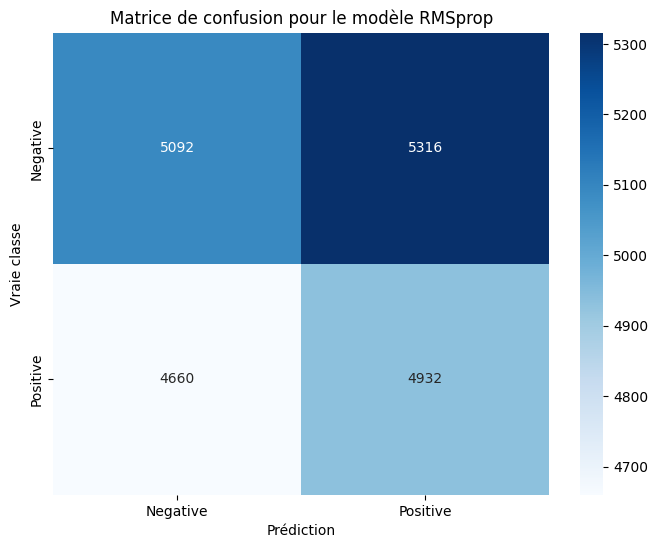

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des étiquettes de classe
class_labels = ['Negative', 'Positive']

# Affichage de la matrice de confusion pour le modèle RMSprop
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rmsprop, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de confusion pour le modèle RMSprop')
plt.xlabel('Prédiction')
plt.ylabel('Vraie classe')
plt.show()


In [48]:
from keras.optimizers import Adagrad

# Création du modèle LSTM avec l'optimiseur Adagrad
model_adagrad = Sequential()
model_adagrad.add(LSTM(100, input_shape=(1, X_train_encoded.shape[1]), activation='relu'))
model_adagrad.add(Dense(1, activation='sigmoid'))

# Compilation du modèle avec l'optimiseur Adagrad
model_adagrad.compile(optimizer=Adagrad(), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history_adagrad = model_adagrad.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))


Epoch 1/10
2500/2500 [==============================] - 26s 8ms/step - loss: 0.6874 - accuracy: 0.6224 - val_loss: 0.6933 - val_accuracy: 0.5031
Epoch 2/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.6754 - accuracy: 0.7243 - val_loss: 0.6942 - val_accuracy: 0.5024
Epoch 3/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.6599 - accuracy: 0.7449 - val_loss: 0.6964 - val_accuracy: 0.5021
Epoch 4/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.6407 - accuracy: 0.7532 - val_loss: 0.7010 - val_accuracy: 0.5009
Epoch 5/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.6185 - accuracy: 0.7598 - val_loss: 0.7092 - val_accuracy: 0.5008
Epoch 6/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.5947 - accuracy: 0.7653 - val_loss: 0.7218 - val_accuracy: 0.5019
Epoch 7/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.5709 - accuracy: 0.7707 - val_loss: 0.7390 - val_ac

In [49]:
# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy)

625/625 [==============================] - 2s 3ms/step - loss: 0.3166 - accuracy: 0.8635
Test Accuracy: 0.8634999990463257


In [56]:
# Prédiction sur les données de validation pour le modèle Adagrad
y_pred_adagrad_probs = model_adagrad.predict(X_val_reshaped)
y_pred_adagrad = (y_pred_adagrad_probs > 0.5).astype('int')  # Conversion en classes
conf_matrix_adagrad = confusion_matrix(y_val, y_pred_adagrad)
print("\nMatrice de confusion pour le modèle Adagrad :\n", conf_matrix_adagrad)

625/625 [==============================] - 4s 5ms/step

Matrice de confusion pour le modèle Adagrad :
 [[5615 4793]
 [5170 4422]]


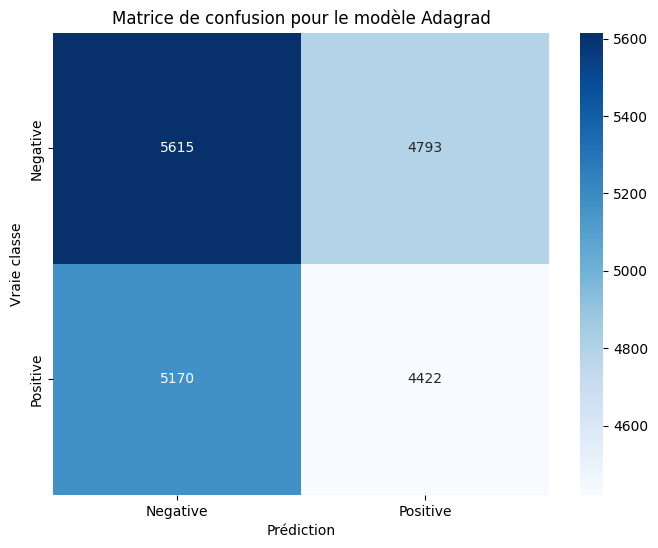

In [57]:

# Affichage de la matrice de confusion pour le modèle Adagrad
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adagrad, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de confusion pour le modèle Adagrad')
plt.xlabel('Prédiction')
plt.ylabel('Vraie classe')
plt.show()